In [ ]:
import os
import pandas as pd
import json
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as T

In [2]:
# 1. Подготовка данных

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transforms=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Получение строки аннотаций
        row = self.annotations.iloc[idx]
        img_path = os.path.join(self.root_dir, row['filename'])
        img = Image.open(img_path).convert("RGB")
        
        # Разбор аннотаций
        region_shape = json.loads(row['region_shape_attributes'])
        region_attr = json.loads(row['region_attributes'])
        
        # Преобразование полигонов в bounding boxes
        all_points_x = region_shape['all_points_x']
        all_points_y = region_shape['all_points_y']
        xmin = min(all_points_x)
        ymin = min(all_points_y)
        xmax = max(all_points_x)
        ymax = max(all_points_y)
        bbox = [xmin, ymin, xmax, ymax]
        
        # Метка класса (например, "car" -> 1)
        label = 1  # Здесь можно добавить маппинг строковых меток в числа
        
        target = {}
        target["boxes"] = torch.tensor([bbox], dtype=torch.float32)
        target["labels"] = torch.tensor([label], dtype=torch.int64)
        
        if self.transforms:
            img = self.transforms(img)
        
        return img, target


In [10]:
# Определение трансформаций
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Инициализация датасета и загрузчика данных
dataset = CustomDataset(csv_file='./annotations/train.csv', root_dir='images', transforms=transform)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [11]:
# 2. Определение модели
def get_model(num_classes):
    # Загрузка предобученной модели Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Получение количества входных признаков для классификатора
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Замена классификатора на новый с num_classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [12]:
# Предположим, у нас есть 2 класса: фон и автомобиль
num_classes = 2
model = get_model(num_classes)

/home/geonode/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/geonode/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Отправка модели на доступное устройство
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [14]:
# 3. Обучение модели

# Определение оптимизатора
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

In [15]:
# Количество эпох
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Прямой проход
        loss_dict = model(images, targets)
        
        # Сумма всех потерь
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    print(f"Эпоха {epoch+1}/{num_epochs}, Потери: {epoch_loss/len(data_loader)}")

print("Обучение завершено!")

Эпоха 1/10, Потери: 0.605057729408145
Эпоха 2/10, Потери: 0.3052748152986169
Эпоха 3/10, Потери: 0.2394067384302616
Эпоха 4/10, Потери: 0.20856718719005585
Эпоха 5/10, Потери: 0.17874368466436863
Эпоха 6/10, Потери: 0.16649540653452277
Эпоха 7/10, Потери: 0.16678534634411335
Эпоха 8/10, Потери: 0.15805188287049532
Эпоха 9/10, Потери: 0.14485096978023648
Эпоха 10/10, Потери: 0.14838020876049995
Обучение завершено!


In [16]:
torch.save(model.state_dict(), 'faster_rcnn_model.pth')

In [17]:
# Загрузка модели
model = get_model(num_classes)
model.load_state_dict(torch.load('faster_rcnn_model.pth'))
model.to(device)
model.eval()

/tmp/ipykernel_223358/906558190.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('faster_rcnn_model.pth'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [19]:
# Предсказание
with torch.no_grad():
    img = Image.open('./test/test.png').convert("RGB")
    img = transform(img).to(device)
    predictions = model([img])
    print(predictions)

[{'boxes': tensor([[1123.1628, 3377.8347, 1168.8613, 3437.1973],
        [2279.2839, 1486.7111, 2333.6460, 1549.2614],
        [4290.2251, 1627.9213, 4342.3228, 1694.4224],
        [4097.6016, 1886.7828, 4167.5640, 1938.5204],
        [2504.5073, 1862.1942, 2547.5774, 1921.2745],
        [1980.7581, 1355.2888, 2027.2434, 1407.2708],
        [2114.4561, 1034.2194, 2154.2258, 1090.5760],
        [4233.8086, 1761.4718, 4281.5283, 1828.3314],
        [3879.2583, 1682.7474, 3928.2532, 1742.8706],
        [1278.4578, 3086.5784, 1316.8264, 3139.8850],
        [2036.6179, 1204.9069, 2081.1536, 1264.5197],
        [2451.2219,   38.6371, 2507.3823,  100.3970],
        [2413.2161, 1130.6169, 2458.9624, 1197.1721],
        [2365.3987,   43.8448, 2417.3936,  110.4438],
        [3264.4077, 2834.6453, 3319.6060, 2886.7190],
        [1449.5657, 2330.4785, 1491.9656, 2382.7903],
        [2332.0396,  641.9657, 2392.3848,  693.5734],
        [1316.5411, 2847.3010, 1364.7881, 2914.3774],
        [ 392.327

In [31]:
# Загрузка меток (замените на соответствующий вам словарь классов)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'car'
]


In [26]:
# Функция для рисования ограничительных рамок
def draw_boxes(image, boxes, labels, scores, threshold=0.5):
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            # Разделение координат рамки
            xmin, ymin, xmax, ymax = box
            # Рисование прямоугольника
            draw.rectangle(((xmin, ymin), (xmax, ymax)), outline="red", width=2)
            # Подпись с именем класса и вероятностью
            text = f"{COCO_INSTANCE_CATEGORY_NAMES[label]}: {score:.2f}"
            text_size = draw.textsize(text, font=font)
            draw.rectangle(((xmin, ymin - text_size[1]), (xmin + text_size[0], ymin)), fill="red")
            draw.text((xmin, ymin - text_size[1]), text, fill="white", font=font)
    return image

In [30]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import torchvision.transforms as T

Количество объектов по категориям:
car: 45


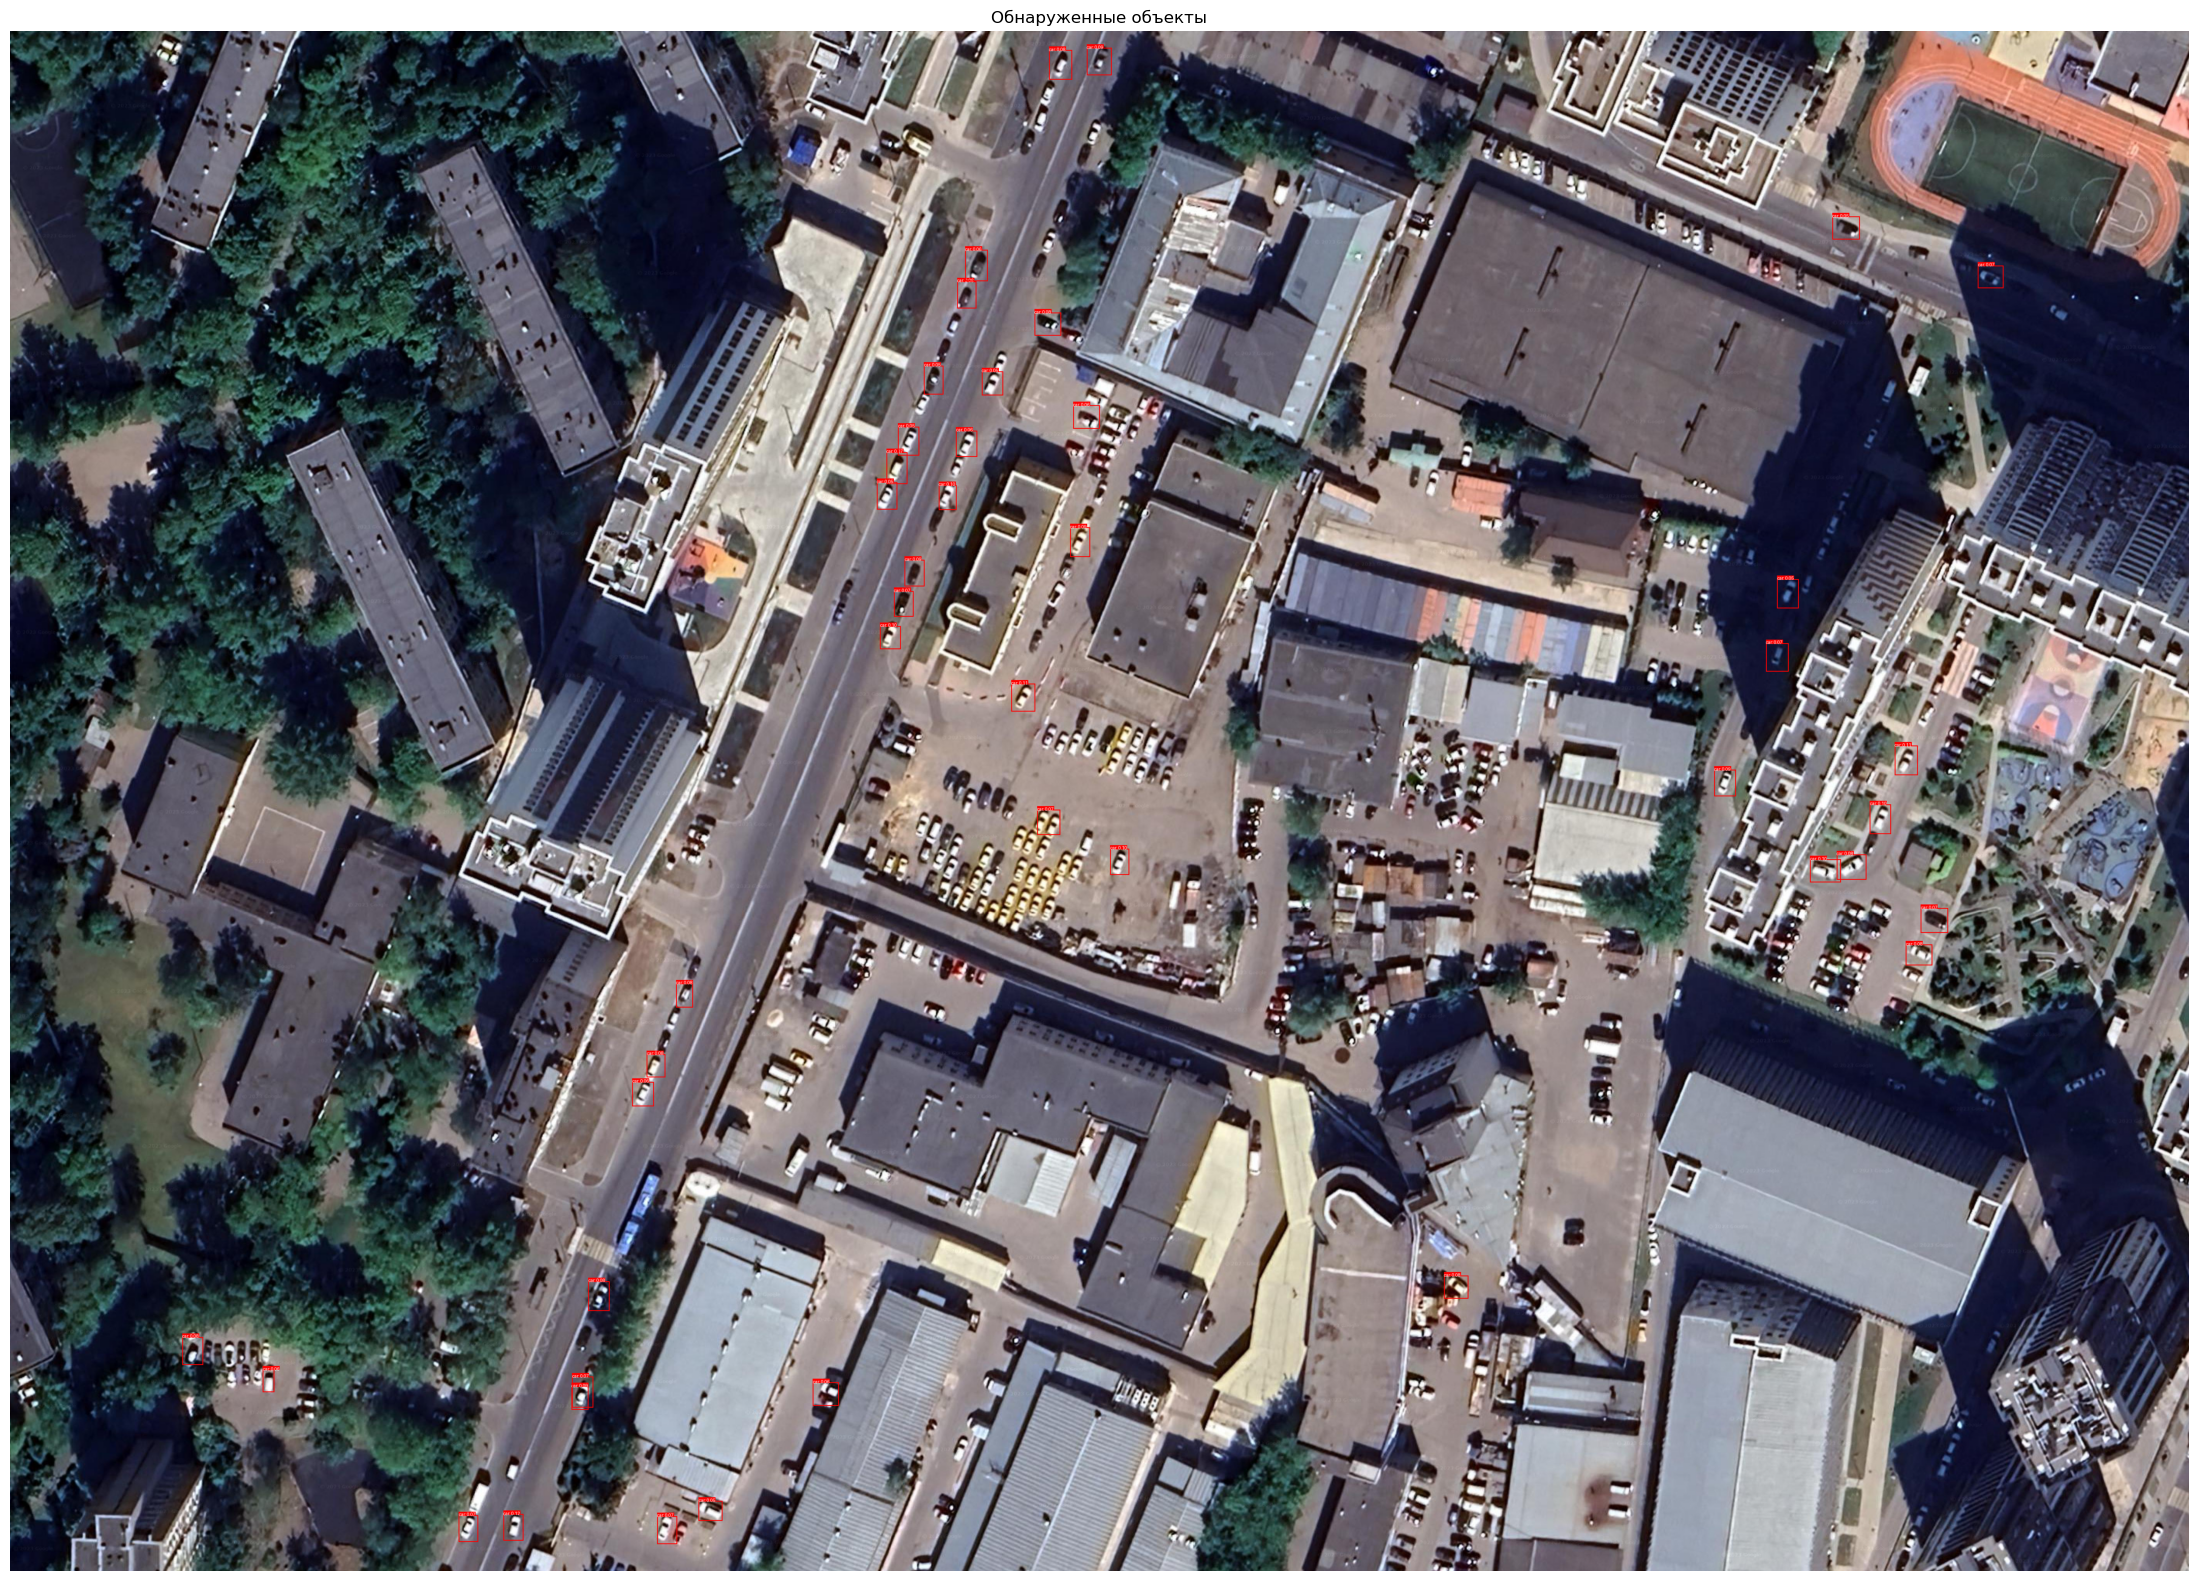

Изображение с ограничительными рамками сохранено по пути: ./test/output_with_boxes.png


In [41]:
# Функция для рисования ограничительных рамок
def draw_boxes(image, boxes, labels, scores, threshold=0.5, category_names=None):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.truetype("arial.ttf", size=55)
    except IOError:
        # Если arial.ttf недоступен, используем стандартный шрифт
        font = ImageFont.load_default()
    
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            # Рисуем прямоугольник
            draw.rectangle(((xmin, ymin), (xmax, ymax)), outline="red", width=2)
            # Формируем текст для подписи
            if category_names:
                if label < len(category_names):
                    category = category_names[label]
                else:
                    category = f"Label {label}"
            else:
                category = str(label)
            text = f"{category}: {score:.2f}"
            # Используем textbbox для получения размера текста
            text_bbox = draw.textbbox((0, 0), text, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            text_size = (text_width, text_height)
            # Рисуем фон для текста
            draw.rectangle(((xmin, ymin - text_height), (xmin + text_width, ymin)), fill="red")
            # Рисуем текст
            draw.text((xmin, ymin - text_height), text, fill="white", font=font)
    return image

# Выбор порога уверенности
threshold = 0.01  # Учитывая низкие оценки, устанавливаем низкий порог

# Обработка предсказаний
pred = predictions[0]
boxes = pred['boxes'].cpu().numpy()
labels = pred['labels'].cpu().numpy()
scores = pred['scores'].cpu().numpy()

# Фильтрация по порогу уверенности
filtered_indices = scores >= threshold
filtered_boxes = boxes[filtered_indices]
filtered_labels = labels[filtered_indices]
filtered_scores = scores[filtered_indices]

# Подсчет объектов по категориям
label_counts = Counter(filtered_labels)
print("Количество объектов по категориям:")
for label, count in label_counts.items():
    if label < len(COCO_INSTANCE_CATEGORY_NAMES):
        category = COCO_INSTANCE_CATEGORY_NAMES[label]
    else:
        category = f"Label {label}"
    print(f"{category}: {count}")

# Отрисовка рамок на изображении
img_with_boxes = img.copy()
img_with_boxes = draw_boxes(
    img_with_boxes,
    filtered_boxes,
    filtered_labels,
    filtered_scores,
    threshold=threshold,
    category_names=COCO_INSTANCE_CATEGORY_NAMES
)

# Отображение изображения с рамками
plt.figure(figsize=(30, 20))
plt.imshow(img_with_boxes)
plt.axis('off')
plt.title('Обнаруженные объекты')
plt.show()

# (Опционально) Сохранение изображения с рамками
output_path = './test/output_with_boxes.png'  # Замените на желаемый путь
img_with_boxes.save(output_path)
print(f"Изображение с ограничительными рамками сохранено по пути: {output_path}")
